# 2012年2023年全国天气状况及趋势分析报告
## 1. 摘要
    本研究以2012年至2023年中国十大主要城市的天气数据为基础，重点分析了这段时间内气温的变化趋势。通过对年平均气温的统计和分析，揭示了不同城市的气温变化特征。研究发现，大多数城市呈现出气温周期性变化的特点，但也存在一定的城市间差异。未来的研究可以进一步探讨气候变化对城市生活和经济的影响，以及提出相应的应对策略。
## 2. 引言
    天气对人类生活和社会经济发展具有重要影响，了解天气状况及其变化趋势对于人民生活、农业、交通、旅游等方面都具有重要意义。本研究旨在通过对中国主要城市天气数据的分析，为相关领域的决策提供参考依据。

## 3. 研究方法
    本研究所使用的数据来自于国内主流天气网站www.tianqi.com，2012年至2023年间中国十大主要城市的气象台数据，包括气温、天气、风向、等多个指标。通过使用Python及其数据分析主流库：Pandas、Numpy及可视化主流库完成本研究的数据获取、数据清洗、特征抽取以及数据分析。
    数据分析的方法主要包括统计分析、时间序列分析等。
## 4. 代码实现

### 4.1 导入所需库 

In [371]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import bs4
import requests
import datetime
import time
import os

###  4.2 获取主要城市天气数据

In [7]:
        
def get_data(y, m, name_chs):
    g_cityName = city_dict[name_chs][0]
    #请求头
    request_headers = {
                        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
                        'cookie': 'UserId=17070304970936990; cityPy=guangzhou; cityPy_expire=1707659568; UserId=17070547733053731'
                        }
    # 构造请求URL
    url = f'https://lishi.tianqi.com/{g_cityName}/{y+m}.html'
    print('请求URL：', url)
    print(f'正在获取{name_chs}在{y}年{m}月的天气数据...')
    # 发送请求
    # 注意：这里需要调整请求头，否则可能会被网站服务器识别为恶意请求而返回403错误
    response = requests.get(url=url,headers=request_headers)
    
    if response.status_code == 200:
        print(f'请求返回代码：{response.status_code}，成功')
        return response
    else:
        # 记录请求失败记录，用于后续重试
        fail_log =  f"{url} 网页请求失败, 失败码：{response.status_code}"
        with open('fail_log.txt', 'a', encoding='utf-8') as f:
            f.write(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + ' ' + fail_log + '\n')
            print('--------------------------------------------------------------------------------------------------------------------')
            print(fail_log)
            
        return 0

def storage_data(rs):
    # 解析网页内容
    soup = bs4.BeautifulSoup(rs.text,'html.parser')
    columns_name = ['date', 'city', 'weekdays', 'high_temp','low_temp','weather', 'w_direct', 'w_force']
    datas = soup.select("body > div.main.clearfix > div.main_left.inleft > div.tian_three > ul")
    try: datas = datas[0].text.strip().split('\n')
    except IndexError:
        print('数据异常，无法解析')
        return 0
    datas = [data for data in datas if data != '' and data != '查看更多']
    new_datas = []
    count = 0
    temp_data = []
    weekdays =  ['星期一','星期二','星期三','星期四','星期五','星期六','星期日']
    for i in datas:
        i = i.strip().split()
        temp_data.extend(i)
        count += 1
        if  count == 5:
            temp_data.insert(1, cityName_chs)
            if len(temp_data) == 7:
                temp_years, temp_months, temp_days = temp_data[0].split('-')
                weekday = datetime.datetime(int(temp_years), int(temp_months), int(temp_days)).weekday() 
                temp_data.insert(2, weekdays[weekday])
            new_datas.append(temp_data)
            temp_data = []
            count = 0
    print(f'天气数据获取成功！共有{len(new_datas)}条数据')
    # 转换为DataFrame
    print(f'天气数据开始转换为DataFrame...')
    try: 
        df =  pd.DataFrame(new_datas, columns=columns_name)
        
    except  ValueError:
        with open ('error.txt', 'a+', encoding='utf-8') as f:
            f.write(f'{cityName_chs}-{year}-{month}-数据异常，无法转换DataFrame\n')
        print(new_datas)
        print('-'*50)
        return 0
    print(f'{cityName_chs}在{year}年{month}月的天气数据转换为DataFrame成功！')
    # 保存数据至CSV文件
    if not os.path.exists('weather.csv'):
        df.to_csv('weather.csv', index=False)
    else:
        df.to_csv('weather.csv', mode='a+', header=False, index=False)    
    print(f'天气数据已保存到CSV文件中！')
    return 1
            
city_dict = {'北京':['beijing',0], 
             '上海':['shanghai',1],
             '广州':['guangzhou',2],
             '深圳':['shenzhen',3],
             '天津':['tianjin',4],
             '重庆':['chongqing',5],
             '武汉':['wuhan',6],
             '西安':['xian',7],
             '哈尔滨':['haerbin',8],
             '成都':['chengdu',9]}
                           
month_dict = {  1:'01', 2:'02', 3:'03', 4:'04',
                5:'05', 6:'06', 7:'07', 8:'08',
                9:'09', 10:'10', 11:'11', 12:'12'
              }
begin_year = 2012
begin_month = 1
city_code = 0
success_count = 0
fail_count = 0
skip_count = 0
s60 = 0
ok_lists = []

# 读取已爬数据，用于筛选已爬数据，避免重复爬取
if os.path.exists('process.txt'):
    print('发现process.txt文件，正在筛选已爬数据')
    with open('process.txt','r',encoding='utf-8') as f:
        lines =  f.readlines()
        for i in lines:
            i = i.split('-')[0:3]
            ok_lists.append(i)
    print(f'筛选完成,当前已爬数据月份{len(ok_lists)}条')

# 遍历城市
for i in range(city_code, len(city_dict)):
    cityName_chs = list(city_dict.keys())[i]
    cityName = city_dict[cityName_chs][0]
    city_code =  city_dict[cityName_chs][1]
    print(f'正在爬取{cityName_chs}')
    for year in range(begin_year,2024):
        for month in range(begin_month,13):
            if month < 10:
                month = '0' + str(month)
            month = str(month)
            year = str(year)
            check_list = [cityName_chs, year, month]
            #  检查是否已爬取
            if check_list in ok_lists:
                print(f'城市{check_list[0]},年份{check_list[1]},月份{check_list[2]}已爬取，跳过')
                continue
            
            response = get_data(year, month, cityName_chs)
            # 防反爬机制，失败重试
            while response == 0:
                if fail_count >= 10:
                    print(f'{cityName_chs}-{year}-{month}-天气数据获取失败，超过最大失败次数，等待60秒后重新获取')
                    time.sleep(60)
                    fail_count = 0
                    s60 += 1
                elif  s60 >= 10:
                    print('超过最大等待次数，程序退出')
                    exit()
                else:
                    print(f'{cityName_chs}-{year}-{month}-天气数据获取失败，10秒后重新获取重新获取,当前失败次数为{fail_count}')
                    time.sleep(10)
                    fail_count += 1
                response = get_data(year, month, cityName_chs)
            
            #  获取数据并验证数据是否为空，为空则继续向下获取
            data_store = storage_data(response)
            if data_store == 0:
                print(f'{cityName_chs}-{year}-{month}-页面获取空数据！继续向下获取')
                fail_log =  f"{cityName_chs}-{year}-{month}-页面获取空数据！"
                with open('fail_log.txt', 'a', encoding='utf-8') as f:
                    f.write(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + ' ' + fail_log + '\n')
                # for i in range(5,0,-1):
                #     print(f'等待{i}分钟后继续获取')
                #     time.sleep(60)
                
                skip_count += 1
                print(f'当前已跳过{skip_count}个城市的天气数据,成功获取{success_count}个城市的天气数据')
                print('--------------------------------------------------------------------------------------------------------------------')
                
            # 记录爬取进度，避免后续断点续存时重复爬取数据
            else:
                with open('process.txt', 'a+', encoding='utf-8') as f:
                    f.write(f'{cityName_chs}-{year}-{month}-天气数据获取完成\n')
                success_count += 1
                time.sleep(10)
                print(f'当前已成功获取{success_count}组数据')
                print('--------------------------------------------------------------------------------------------------------------------')
                if success_count % 10 == 0:
                    print(f'已连续获取10个月数据，等待1分钟后继续')
                    time.sleep(60)
            
            
                
        begin_month = 1
    begin_year = 2012

print(f'爬取完成，共获取{success_count}组数据，跳过{skip_count}组数据')

发现process.txt文件，正在筛选已爬数据
筛选完成,当前已爬数据月份1440条
正在爬取北京
城市北京,年份2012,月份01已爬取，跳过
城市北京,年份2012,月份02已爬取，跳过
城市北京,年份2012,月份03已爬取，跳过
城市北京,年份2012,月份04已爬取，跳过
城市北京,年份2012,月份05已爬取，跳过
城市北京,年份2012,月份06已爬取，跳过
城市北京,年份2012,月份07已爬取，跳过
城市北京,年份2012,月份08已爬取，跳过
城市北京,年份2012,月份09已爬取，跳过
城市北京,年份2012,月份10已爬取，跳过
城市北京,年份2012,月份11已爬取，跳过
城市北京,年份2012,月份12已爬取，跳过
城市北京,年份2013,月份01已爬取，跳过
城市北京,年份2013,月份02已爬取，跳过
城市北京,年份2013,月份03已爬取，跳过
城市北京,年份2013,月份04已爬取，跳过
城市北京,年份2013,月份05已爬取，跳过
城市北京,年份2013,月份06已爬取，跳过
城市北京,年份2013,月份07已爬取，跳过
城市北京,年份2013,月份08已爬取，跳过
城市北京,年份2013,月份09已爬取，跳过
城市北京,年份2013,月份10已爬取，跳过
城市北京,年份2013,月份11已爬取，跳过
城市北京,年份2013,月份12已爬取，跳过
城市北京,年份2014,月份01已爬取，跳过
城市北京,年份2014,月份02已爬取，跳过
城市北京,年份2014,月份03已爬取，跳过
城市北京,年份2014,月份04已爬取，跳过
城市北京,年份2014,月份05已爬取，跳过
城市北京,年份2014,月份06已爬取，跳过
城市北京,年份2014,月份07已爬取，跳过
城市北京,年份2014,月份08已爬取，跳过
城市北京,年份2014,月份09已爬取，跳过
城市北京,年份2014,月份10已爬取，跳过
城市北京,年份2014,月份11已爬取，跳过
城市北京,年份2014,月份12已爬取，跳过
城市北京,年份2015,月份01已爬取，跳过
城市北京,年份2015,月份02已爬取，跳过
城市北京,年份2015,月份03已爬取，跳过
城市北京,年份2015,月份04已爬取，跳过
城市北京,年份2015,月份05已爬取，跳过
城市北京,年

### 4.3 数据清洗

 #### 数据清洗步骤：
 1. 读取csv，规整表内数据，并对天气数据进行一定分列，方面后续统计

In [222]:
# 读取csv文件
df =  pd.read_csv('weather.csv')
# 将日期列转换为datetime格式
df.date = pd.to_datetime(df.date)
dfs = []
# 对dataframe按日期重新排序
for i in city_dict.items():
    temp_df = df[df['city'] == i[0]].sort_values(by='date')
    dfs.append(temp_df)
fine_df = pd.concat(dfs,ignore_index=True)
# 以日期和城市为索引
# fine_df.set_index(['date','city'],inplace=True)
# 计算平均温度
fine_df['avg_temp'] = fine_df[['high_temp', 'low_temp']].mean(axis=1)

# 拆分天气情况
split_weather = df['weather'].str.split('~', expand=True)
if len(split_weather.columns) == 1:
    split_weather[1] = split_weather[0]
    
split_weather.columns = ['weather1', 'weather2']
split_weather.index = fine_df.index

fine_df = pd.concat([fine_df, split_weather], axis=1) if  'weather2' not in fine_df else fine_df
fine_df.drop('weather', axis=1, inplace=True) if   'weather' in fine_df else fine_df

# 拆分风向和风速
split_w_direct = df['w_direct'].str.split('~', expand=True)
if len(split_w_direct.columns) == 1:
    split_w_direct[1] = split_w_direct[0]

split_w_direct.columns = ['w_direct1', 'w_direct2']
split_w_direct.index = fine_df.index


fine_df = pd.concat([fine_df, split_w_direct], axis=1) if  'w_direct2' not in fine_df else fine_df
fine_df.drop('w_direct', axis=1, inplace=True) if   'w_direct' in fine_df  else fine_df

split_w_force = df['w_force'].str.split('~', expand=True)
if len(split_w_force.columns) == 1:
    split_w_force[1] = split_w_force[0]

split_w_force.columns = ['w_force1', 'w_force2']
split_w_force.index = fine_df.index

fine_df = pd.concat([fine_df, split_w_force], axis=1) if  'w_force2' not in fine_df else fine_df
fine_df.drop('w_force', axis=1, inplace=True) if   'w_force' in fine_df else fine_df

fine_df

,date,city,weekdays,high_temp,low_temp,avg_temp,weather1,weather2,w_direct1,w_direct2,w_force1,w_force2
0,2012-01-01,北京,星期日,3,-4,-0.5,多云,阴,无持续风向,None,微风,None
1,2012-01-02,北京,星期一,2,-6,-2.0,晴,None,北风,None,4-5级,None
2,2012-01-03,北京,星期二,1,-8,-3.5,晴,None,北风,无持续风向,3-4级,微风
3,2012-01-04,北京,星期三,1,-10,-4.5,晴,None,无持续风向,None,微风,None
4,2012-01-05,北京,星期四,2,-8,-3.0,晴,多云,无持续风向,None,微风,None
...,...,...,...,...,...,...,...,...,...,...,...,...
43815,2023-12-27,成都,星期三,14,4,9.0,阵雨,None,西南风,None,3-4级,微风
43816,2023-12-28,成都,星期四,10,6,8.0,阵雨,多云,西南风,西风,4-5级,3-4级
43817,2023-12-29,成都,星期五,16,5,10.5,阵雨,多云,西风,西北风,3-4级,微风
43818,2023-12-30,成都,星期六,13,4,8.5,雷阵雨,None,西风,西南风,3-4级,微风


2. 对空数据进行处理
    经查询，当前数据集中存在若干风向、风速数据为空，需要将这些数据进行填充，
    由于数量不多，且内容较为容易复制，因此选择通过手动方式进行填充，填充方式：选择其他数据源，进行数据补充。（数据源：http://www.tianqihoubao.com/）
  
3. 对非标准数据进行处理
    经查询，当前数据集中可能由于数据源迭代问题，部分字段内容存在变化，如部分星期字段内容存在类似”周一“、”星期一“的不同称谓。风速亦存在类似”1~2级“，”小于3级”的不同衡量标准，
    为了后续可视化和数据统计的便利性，需要将所有数据统一化，统一使用标准化的衡量标准。
  
4. 对存在重复数据进行处理
    经查询，前期由于爬虫脚本存在问题，导致在重试时没有忽略已保存数据、使得部分月份数据重复，后通过调整爬虫脚本，避免了该问题，并手动删除了所有重复数据。

5. 对缺失数据进行处理
    经查询，部分单日天气数据存在缺失，需要对缺失数据进行填充，填充方式：选择其他数据源，进行数据补充。（数据源：http://www.tianqihoubao.com/）

6. 重新排序数据
    由于部分数据源在爬取时，经过多次重试，导致数据顺序混乱，需要对数据重新排序。

7. 查找发现不正常数据
    通过标准分数分析(Z-score)，滚动计算异常数据，并对该数据进行多数据源比对，确认其准确值

In [84]:
# 使用标准分数分析(Z-score)计算异常数据
print(fine_df.describe())

def calculate_z_score(column_n):
    rolling_mean = column_n.rolling(window=7).mean()
    rolling_std = column_n.rolling(window=7).std()
    z_score = (column_n - rolling_mean) / rolling_std
    return z_score


z_score_cities_hi = fine_df.groupby('city', group_keys=False)['high_temp'].apply(calculate_z_score)
z_score_cities_lo = fine_df.groupby('city', group_keys=False)['low_temp'].apply(calculate_z_score)
z_score_cities_avg =  fine_df.groupby('city', group_keys=False)['avg_temp'].apply(calculate_z_score)
abnormal_data1 = fine_df[abs(z_score_cities_hi) > 3]
abnormal_data2 = fine_df[abs(z_score_cities_lo) > 3]
abnormal_data3 = fine_df[abs(z_score_cities_avg) > 3]
print(abnormal_data1)
print(abnormal_data2)
print(abnormal_data3)


                                date     high_temp      low_temp      avg_temp
count                          43820  43820.000000  43820.000000  43820.000000
mean   2017-12-31 01:39:14.541305344     20.954678     12.817686     16.886182
min              2012-01-01 00:00:00    -25.000000    -35.000000    -30.000000
25%              2014-12-31 00:00:00     14.000000      6.000000      9.500000
50%              2017-12-31 12:00:00     23.000000     15.000000     19.000000
75%              2020-12-31 00:00:00     30.000000     22.000000     25.500000
max              2023-12-31 00:00:00     43.000000     36.000000     38.500000
std                              NaN     10.833655     11.039288     10.798479
Empty DataFrame
Columns: [date, city, weekdays, high_temp, low_temp, avg_temp, weather1, weather2, w_direct1, w_direct2, w_force1, w_force2]
Index: []
Empty DataFrame
Columns: [date, city, weekdays, high_temp, low_temp, avg_temp, weather1, weather2, w_direct1, w_direct2, w_force1, w_force

  经整理，可知本数据集并无异常数据。

### 4.4 数据挖掘
4.4.1 十城天气概况：

In [369]:
# 统计十城最高最低气温、平均气温、气温中位数及测得日期
max_temp_index = fine_df.groupby('city')['high_temp'].idxmax()
min_temp_index = fine_df.groupby('city')['low_temp'].idxmin()

max_temp_rows =  fine_df.loc[max_temp_index]
min_temp_rows =  fine_df.loc[min_temp_index]

max_temp_cities = max_temp_rows['city'].tolist()
min_temp_cities = min_temp_rows['city'].tolist()
max_temp_dates =  max_temp_rows['date'].tolist()
min_temp_dates =  min_temp_rows['date'].tolist()

total_avg_temp = fine_df.groupby('city')['avg_temp'].mean()
mid_temp = fine_df.groupby('city')['avg_temp'].median()


# 统计十城的最频繁或最少天气
freq_weather_city = {}
for city in fine_df['city'].unique():
    city_data = fine_df[fine_df['city'] == city]
    combine_col1 = pd.concat([city_data['weather1'], city_data['weather2']])
    freq_weather_city[city] = combine_col1.value_counts()

# 统计十城的最频繁风向和最少风向
freq_wind_direct_city = {}
for city in fine_df['city'].unique():
    city_data = fine_df[fine_df['city'] == city]
    combine_col2 = pd.concat([city_data['w_direct1'], city_data['w_direct2']])
    freq_wind_direct_city[city] = combine_col2.value_counts()
    
#  统计十城的最频繁风力和最少风力
freq_wind_force_city = {}
for  city in fine_df['city'].unique():
    city_data = fine_df[fine_df['city'] == city]
    combine_col3 = pd.concat([city_data['w_force1'], city_data['w_force2']])
    freq_wind_force_city[city] = combine_col3.value_counts()

print('十城城市历史天气概况')
for i in range(len(max_temp_cities)):
    print('-'*30)
    print(f"{max_temp_cities[i]}近12年最高温度：{max_temp_rows.iloc[i]['high_temp']}℃，录得日期：{max_temp_dates[i].strftime('%Y-%m-%d')}")
    print(f"{min_temp_cities[i]}近12年最低温度：{min_temp_rows.iloc[i]['low_temp']}℃，录得日期：{min_temp_dates[i].strftime('%Y-%m-%d')}")
    print(f"{max_temp_cities[i]}年平均温度：{total_avg_temp.iloc[i]:.2f}℃")
    print(f"{max_temp_cities[i]}温度中位数：{mid_temp.iloc[i]}℃")
    print(f"{max_temp_cities[i]}最常出现的天气：{freq_weather_city[max_temp_cities[i]].idxmax()}，近12年出现次数为{freq_weather_city[max_temp_cities[i]].max()}")
    print(f"{min_temp_cities[i]}的罕见天气为：{freq_weather_city[max_temp_cities[i]].idxmin()}，近12年出现次数为{freq_weather_city[max_temp_cities[i]].min()}")
    print(f"{max_temp_cities[i]}最常出现的风向为：{freq_wind_direct_city[max_temp_cities[i]].idxmax()}，近12年出现次数为{freq_wind_direct_city[max_temp_cities[i]].max()}")
    print(f"{min_temp_cities[i]}的罕见风向为：{freq_wind_direct_city[max_temp_cities[i]].idxmin()}，近12年出现次数为{freq_wind_direct_city[max_temp_cities[i]].min()}")
    print(f"{max_temp_cities[i]}最常出现的风力为：{freq_wind_force_city[max_temp_cities[i]].idxmax()}，近12年出现次数为{freq_wind_force_city[max_temp_cities[i]].max()}")
    print(f"{min_temp_cities[i]}的罕见风力为：{freq_wind_force_city[max_temp_cities[i]].idxmin()}，近12年出现次数为{freq_wind_force_city[max_temp_cities[i]].min()}")


city
上海     18.196372
北京     13.754222
哈尔滨     5.335235
天津     14.741100
广州     23.204131
成都     17.724441
武汉     17.566408
深圳     23.919329
西安     15.243154
重庆     19.177430
Name: avg_temp, dtype: float64 city
上海     19.0
北京     15.0
哈尔滨     8.0
天津     16.0
广州     24.5
成都     18.5
武汉     18.5
深圳     25.0
西安     16.0
重庆     19.5
Name: avg_temp, dtype: float64
十城城市历史天气概况
------------------------------
上海近12年最高温度：40℃，录得日期：2013-08-07
上海近12年最低温度：-9℃，录得日期：2022-01-01
上海年平均温度：18.20℃
上海温度中位数：19.0℃
上海最常出现的天气：多云，近12年出现次数为2112
上海的罕见天气为：大到暴风雨，近12年出现次数为1
上海最常出现的风向为：西风，近12年出现次数为1017
上海的罕见风向为：无持续风向，近12年出现次数为4
上海最常出现的风力为：小于3级，近12年出现次数为3684
上海的罕见风力为：8级，近12年出现次数为1
------------------------------
北京近12年最高温度：41℃，录得日期：2023-06-22
北京近12年最低温度：-19℃，录得日期：2017-12-27
北京年平均温度：13.75℃
北京温度中位数：15.0℃
北京最常出现的天气：多云，近12年出现次数为1957
北京的罕见天气为：暴雪，近12年出现次数为1
北京最常出现的风向为：微风，近12年出现次数为1200
北京的罕见风向为：西风，近12年出现次数为100
北京最常出现的风力为：小于3级，近12年出现次数为3112
北京的罕见风力为：6-7级，近12年出现次数为1
------------------------------
哈尔滨近12年最高温度：38℃，录得日期：2018-06-02
哈

4.4.2 计算一个城市的月平均气温（以重庆市为例）
    计算重庆市的月平均气温，数据包含月平均气温、最高气温和最低气温。

In [370]:

fine_df['year'] = fine_df['date'].dt.year
fine_df['month'] = fine_df['date'].dt.month

# Group by city, year, and month
grouped = fine_df.groupby(['city', 'year', 'month'])

# Calculate monthly average, highest, and lowest temperatures
monthly_stats = grouped.agg(
    monthly_avg_temp=('avg_temp', 'mean'),
    monthly_high_temp=('high_temp', 'max'),
    monthly_low_temp=('low_temp', 'min'),
)

# Calculate 25th to 75th and 10th to 90th percentile bands for average high and low temperatures
percentiles = grouped.agg(
    avg_temp_25th=('avg_temp', lambda x: x.quantile(0.25)),
    avg_temp_75th=('avg_temp', lambda x: x.quantile(0.75)),
    avg_temp_10th=('avg_temp', lambda x: x.quantile(0.1)),
    avg_temp_90th=('avg_temp', lambda x: x.quantile(0.9)),

)

# Merge the two DataFrames on city, year, and month
avg_temp_df = pd.merge(monthly_stats, percentiles, on=['city', 'year', 'month'])

# Reset index to make city, year, and month as columns
avg_temp_df.reset_index(inplace=True)

# Display the resulting DataFrame
avg_temp_df[avg_temp_df['city']=='重庆']

,city,year,month,monthly_avg_temp,monthly_high_temp,monthly_low_temp,avg_temp_25th,avg_temp_75th,avg_temp_10th,avg_temp_90th
1296,重庆,2012,1,7.177419,13,4,6.75,8.000,6.00,8.00
1297,重庆,2012,2,8.862069,14,5,8.00,9.500,7.50,10.60
1298,重庆,2012,3,14.080645,25,6,11.00,17.500,9.00,19.00
1299,重庆,2012,4,19.233333,30,14,16.50,21.875,16.50,23.50
1300,重庆,2012,5,22.758065,33,17,20.75,25.000,19.50,26.00
...,...,...,...,...,...,...,...,...,...,...
1435,重庆,2023,8,30.129032,39,20,28.00,32.250,25.50,34.00
1436,重庆,2023,9,26.966667,38,20,22.50,30.500,21.50,32.05
1437,重庆,2023,10,19.822581,28,12,18.50,21.000,17.00,23.00
1438,重庆,2023,11,16.300000,25,10,14.50,18.875,12.45,19.55


### 4.5 数据可视化

#### 4.5.1 各年各地平均气温对比

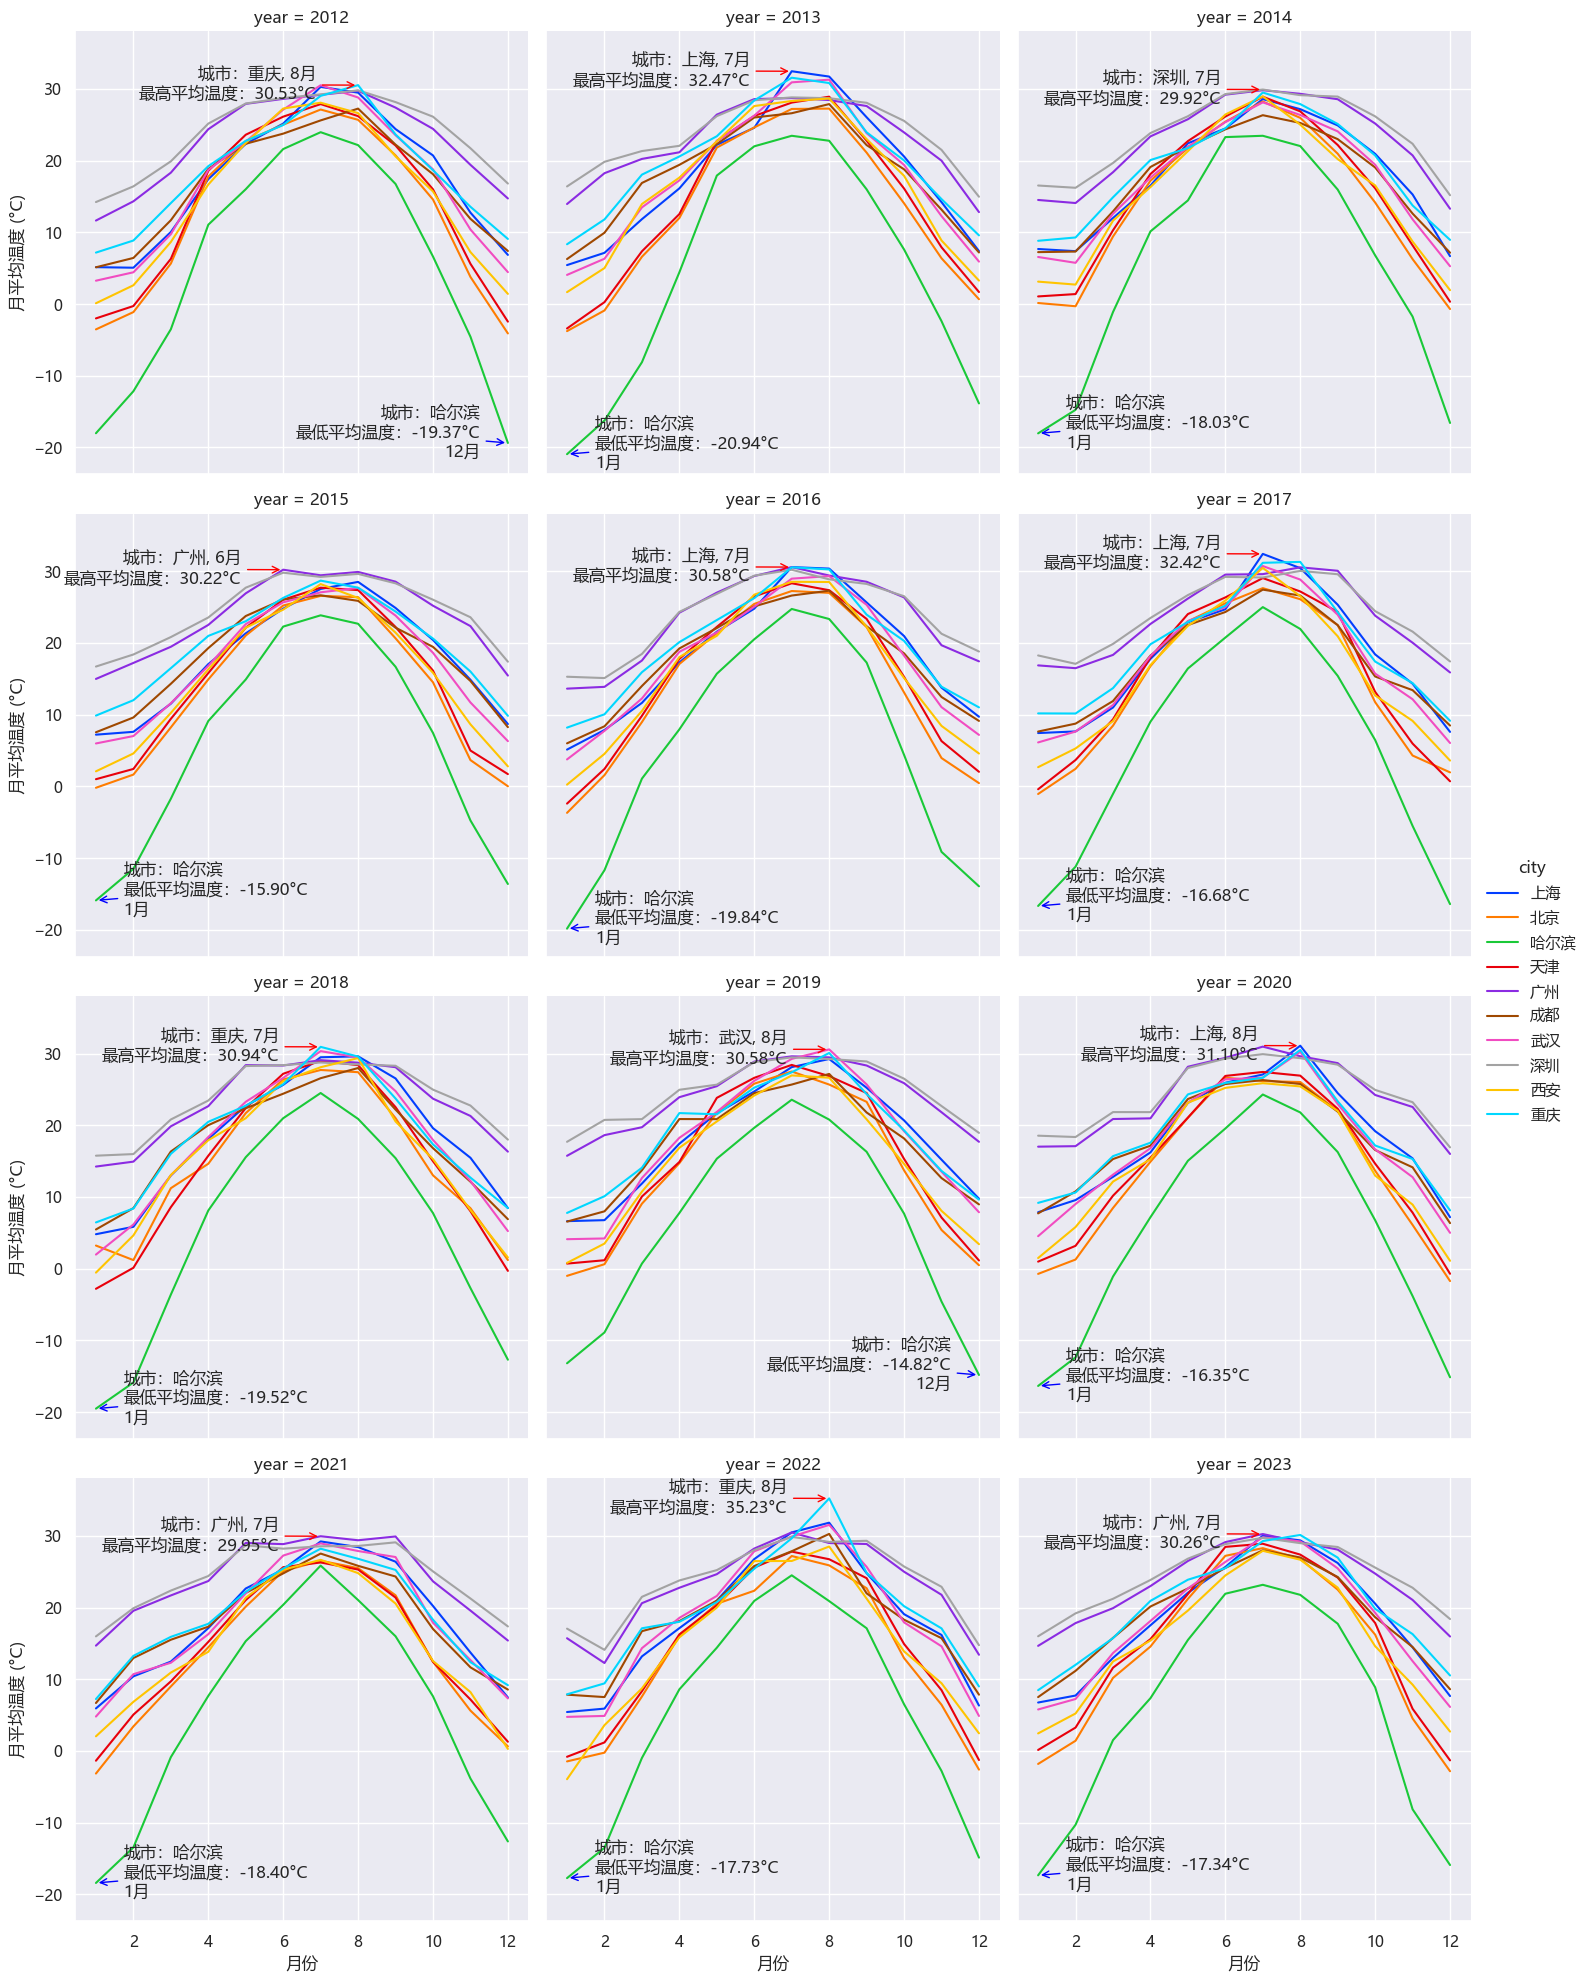

In [191]:
# 设置Matplotlib的字体
font_family = 'Microsoft YaHei'  # Change this to the font you want to use
font_size = 12
font_weight = 'normal'

# 设置Seaborn的主题
plt.rc('font', family=font_family, size=font_size, weight=font_weight)

sns.set()

month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.set_theme(font=font_family)

#  绘制平均气温折线图
avg_temp_graph = sns.relplot(data=avg_temp_df, x='month', y='monthly_avg_temp',col='year', hue='city', kind='line', col_wrap=3, palette=sns.color_palette("bright"))
avg_temp_graph.set_axis_labels("月份", '月平均温度 (°C)')
year = 2012

# 设置指针注释，标注各图最高、最低气温
for ax in avg_temp_graph.axes.flat:
    if ax.lines:        
        highest_temp = np.max(avg_temp_df[avg_temp_df['year']== year].monthly_avg_temp)
        lowest_temp = np.min(avg_temp_df[avg_temp_df['year']== year].monthly_avg_temp)
        highest_index = np.argmax(avg_temp_df[avg_temp_df['year']== year].monthly_avg_temp)
        lowest_index = np.argmin(avg_temp_df[avg_temp_df['year']== year].monthly_avg_temp)
        max_month = avg_temp_df['month'].iloc[highest_index]
        min_month = avg_temp_df['month'].iloc[lowest_index]
        max_city = avg_temp_df[avg_temp_df['year']== year].iloc[highest_index].city
        min_city = avg_temp_df[avg_temp_df['year']== year].iloc[lowest_index].city
        #标示平均最高最低气温
        ax.annotate(f"城市：{max_city}, {max_month}月\n最高平均温度：{highest_temp:.2f}°C", xy=(max_month, highest_temp), 
                    xytext=(-30,-10),textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", color='red'), horizontalalignment='right')
        if min_month >10:
            ax.annotate(f"城市：{min_city}\n最低平均温度：{lowest_temp:.2f}°C\n{min_month}月", xy=(min_month, lowest_temp), 
                        xytext=(-20,-10),textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color='blue'),horizontalalignment='right')
        else:
            ax.annotate(f"城市：{min_city}\n最低平均温度：{lowest_temp:.2f}°C\n{min_month}月", xy=(min_month, lowest_temp), 
                        xytext=(20,-10),textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color='blue'),horizontalalignment='left')
        year += 1

plt.show()

根据上述折线图，可以观察得到以下规律：
1. 由于中国地处北半球，所以所有城市气温曲线均呈现夏季（6月-8月）比冬季（12月-2月）更高的特点。
2. 夏季气温最高的城市是重庆（录得月平均最高温度35.23℃，单日最高温度43℃，发生于2022年8月17日），冬季气温最低的城市是哈尔滨（录得月平均最低温度-20.94℃，单日最低温度-35℃，发生于2023月1月23日。）
3. 所处纬度越低城市，年平均气温差异越低且平均气温较高。相反，所处纬度越高的城市，年平均气温差异越大且平均气温较低。

#### 4.5.2 以重庆市为例，绘制该城市2012年至2023年的平均气温折线图 

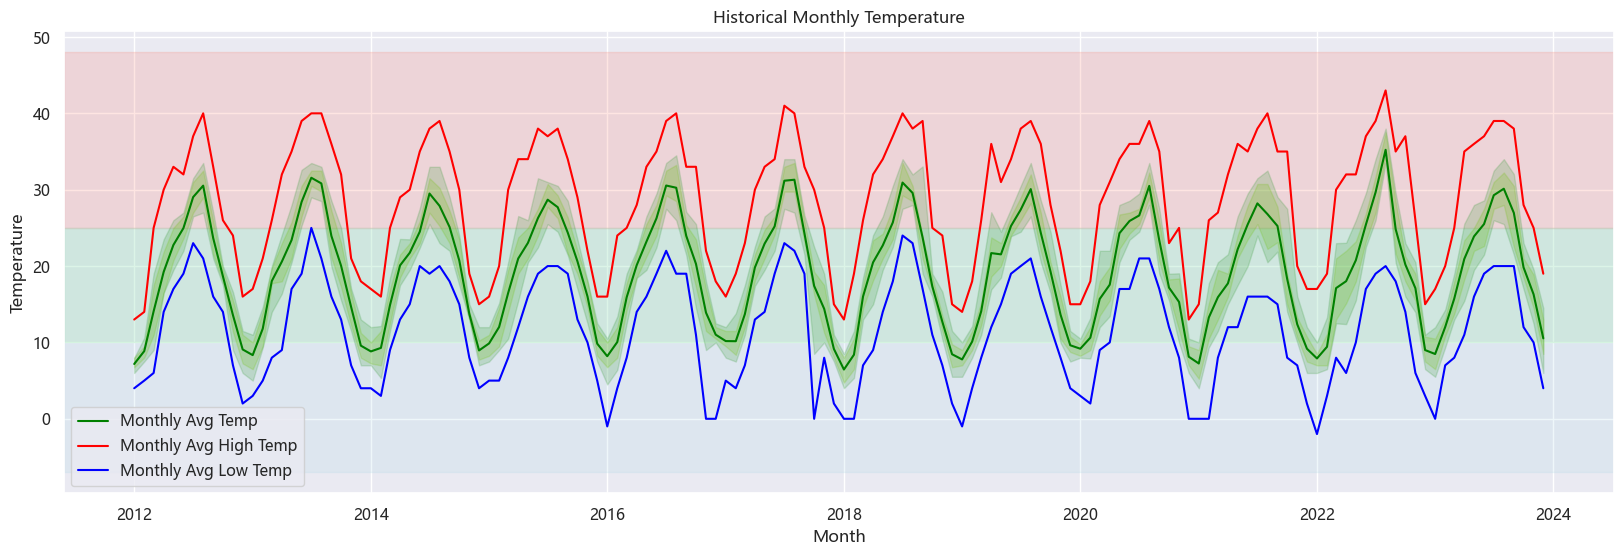

In [211]:
city_weather_df = avg_temp_df[avg_temp_df['city']=='重庆'].copy()
city_weather_df['year_month'] = city_weather_df['year'].astype(str) + '-' + city_weather_df['month'].astype(str)
city_weather_df.loc[:, 'year_month'] = pd.to_datetime(city_weather_df['year_month'])


plt.figure(figsize=(20, 6))
sns.lineplot(data=city_weather_df, x='year_month', y='monthly_avg_temp', color='green', label='Monthly Avg Temp')
sns.lineplot(data=city_weather_df, x='year_month', y='monthly_high_temp',color='red', label='Monthly Avg High Temp')
sns.lineplot(data=city_weather_df, x='year_month', y='monthly_low_temp', color='blue', label='Monthly Avg Low Temp')

plt.axhspan(10, 25, color='lightgreen', alpha=0.2)
plt.axhspan(25, np.max(city_weather_df.monthly_high_temp+5), color='salmon', alpha=0.2)
plt.axhspan(25, np.min(city_weather_df.monthly_low_temp-5), color='lightblue', alpha=0.2)

plt.fill_between(city_weather_df.year_month, city_weather_df.avg_temp_25th, city_weather_df.avg_temp_75th, color=(0.5,0.8,0), alpha=0.2)
plt.fill_between(city_weather_df.year_month, city_weather_df.avg_temp_10th, city_weather_df.avg_temp_90th, color=(0.2,0.6,0.2), alpha=0.2)

plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Historical Monthly Temperature')

# Show plot
plt.show()

根据上述折线图，可以观察出以下规律：
1. 重庆的历史平均温度在呈现周期性变化的同时，也呈现出一定的随机性。
2. 根据气温10\~90%区间，和25~75%区间分布带，我们可以看到重庆气温呈现冬夏波动较大，春秋波动较少的特点。
3. 按照气温在10℃\~25℃为人体舒适温度的标准，我们可以看到重庆的气温春秋时节较为怡人，适合作为旅游的季节。

#### 4.5.3 以重庆为例，绘制出该城市2012\~2023年的气温热力图

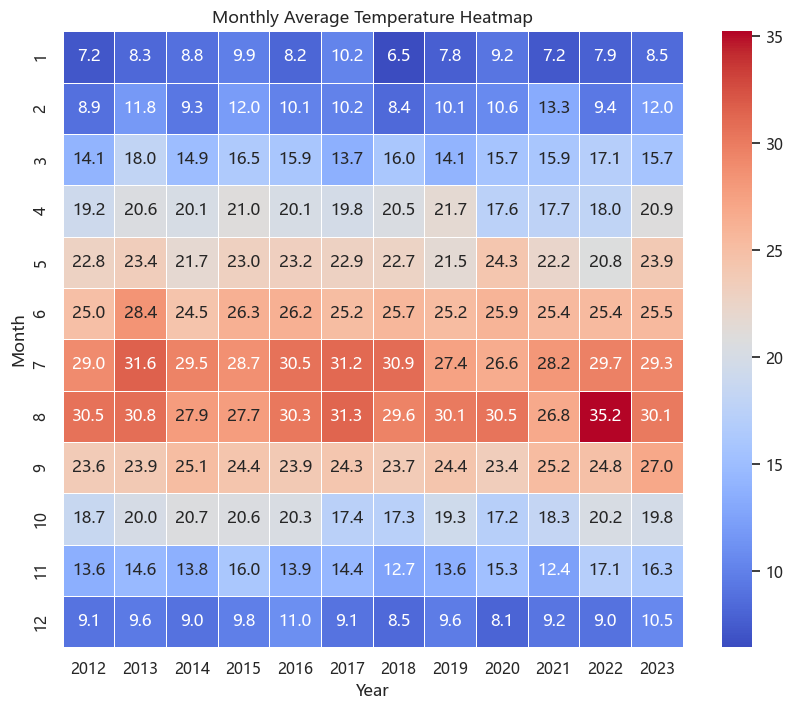

In [194]:
heatmap_data = city_weather_df.pivot(index='month', columns='year', values='monthly_avg_temp')
#  设置热力图的颜色映射
plt.figure(figsize=(10, 8))
sns.heatmap(data=heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('重庆月均平均温度热力图')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

根据上述热力图，我们可以更直观的看到重庆市2012\~2023年的气温变化情况。从图中可以看出，重庆市的气温变化趋势呈现向两极分化波动的情况，冬天的气温会变得更冷，而夏天气温会变得更热。这对当地居民来说则需要更多的措施来应对气温变化。

## 5. 不足与反思

尽管本研究对中国主要城市的气温数据进行了深入分析，但也存在一些不足之处需要进行反思和改进。

首先，本研究仅关注了气温数据的分析，而未对降水量和极端天气事件进行详细分析。这导致了对天气状况的全面理解不足，未能充分揭示气候变化对城市生活和经济的全面影响。未来的研究应该更加全面地考虑多个气象因素，并探讨它们之间的关联性，以便更好地理解气候变化的影响机制。

其次，本研究所使用的数据仅包括了2012年至2023年的时间跨度，时间范围相对较短。虽然我们观察到了一些明显的气温变化趋势，但长期气候变化的研究还需要更长时间的数据支持。未来的研究可以考虑使用更长时间跨度的数据，以便更准确地评估气候变化的长期趋势和影响。

最后，本研究所使用的方法虽然能够揭示一些数据的规律和趋势，但也存在一定的局限性。例如，我们可能未能考虑到一些可能影响气温变化的因素，如大气污染、土地利用变化等。未来的研究可以尝试结合更多的因素，构建更加完整的气候变化模型，以便更准确地预测未来的气候变化趋势。

在未来的研究中，我们将继续努力改进方法和扩展研究范围，以便更全面地理解气候变化对城市的影响，并提出相应的应对策略，为城市的可持续发展做出更大的贡献。


## 6. 结论与展望

本研究聚焦于2012年至2023年中国主要城市的气温数据分析，通过深入研究揭示了这些城市气候状况及其变化趋势。通过对气温数据的统计和分析，我们发现了一些引人注目的趋势和现象。

首先，观察到在这段时间内，大多数城市的气温呈现出明显的周期变化趋势。具体而言，冬季气温较低，夏季气温较高，而春秋季节气温则处于中间水平。这主要与中国所处于北半球，毗邻太平洋所带来的四季分明的自然规律有关。

其次，在不同的城市之间温度变化的差异也很大。在夏天，尽管一些城市的气温相对其他城市较高，但是各地整体气温仍在集中于25~30℃区间。但是在冬季，一些城市的气温仍在15℃以上， 而另一些城市可降至-30℃以下。

最后，虽然当前的数据周期跨度仅仅建立在12年间，在气候研究领域上并不能很直观的查看到明显的变化趋势，但是，我们也注意到，在2012年至2023年之间，各地存在的极端天气事件发生频率有所增加。这一发现可能这一发现可能反映了全球气候变暖的影响，但也可能受到城市化、人口增长、人口迁移等因素的影响。这种极端天气发生概率上升趋势对城市居民的生活、农业生产和能源消耗等方面可能产生重要影响，需要引起政府和社会各界的重视。

在展望方面，我们认为未来的研究可以进一步探讨气候变化对中国主要城市的影响，并提出相应的应对策略。这可能涉及到城市规划、资源管理、应急预案等多个方面，需要政府、学术界和社会各界的共同努力。只有加强对气候变化的认识，才能更好地保护城市居民的生活质量和社会经济的可持续发展。